In [2]:
import json
import os
import sys

sys.path.append('../')
sys.path.append('../../')
sys.path.append('../src')
sys.path.append('../prompts')
sys.path.append('../src/llmperf')

# Run multiple models through the benchmarking process

In [27]:
# results_dir = '../data/results/samsung_switching_time/20250507-194050.002042'
# results_dir = '../data/results/samsung_switching_time/20250507-201534.368448'
# results_dir = '../data/results/samsung_switching_time/20250507-202648.922900'
# results_dir = '../data/results/samsung_switching_time/20250507-204742.928336'

# results_dir = '../data/results/samsung_switching_time/20250507-233407.542853'
# results_dir = '../data/results/samsung_switching_time/20250508-200046.327533'

# results_dir = '../data/results/samsung_switching_time/20250509-145104.461275'
# results_dir = '../data/results/samsung_switching_time/20250509-160314.649552'

# paths related to maitai - may13
# results_dir = '../data/results/samsung_switching_time/20250513-163207.694183'
# results_dir = '../data/results/samsung_switching_time/20250513-164404.192293'
# results_dir = '../data/results/samsung_switching_time/20250513-170214.994133'
# results_dir = '../data/results/samsung_switching_time/20250513-171004.700022'

# paths related to qwen tests - may13
# results_dir = '../data/results/samsung_switching_time/20250513-200948.674911'
# results_dir = '../data/results/samsung_switching_time/20250513-201201.874344'
# results_dir = '../data/results/samsung_switching_time/20250513-203831.379216'
# results_dir = '../data/results/samsung_switching_time/20250513-213019.360794'
# results_dir = '../data/results/samsung_switching_time/20250513-224514.509434'
# results_dir = '../data/results/samsung_switching_time/20250514-145840.246434'
# may 14 
# results_dir = '../data/results/samsung_switching_time/20250515-193312.503886'
# results_dir = '../data/results/samsung_switching_time/20250515-202647.450176'
# results_dir = '../data/results/samsung_switching_time/20250515-221706.141990'
# may 17
# results_dir = '../data/results/samsung_switching_time/20250516-233727.294823'

# may 22 405b
# results_dir = '../data/results/405b_switching_time/20250522-175723.243473'
# results_dir = '../data/results/405b_switching_time/20250522-180321.458809'

# qwen3 + llama3.3 70b 4-16k with copypefs jun 18
results_dir = '../data/results/qwen_llama_switching_time/qwen3_32b_llama3.3_70b_4k-16k_copypefs/20250618-111153.105710'

# Analyze metrics through models

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from benchmarking.utils import read_perf_eval_json_files

## Read the input json file

In [18]:
df = read_perf_eval_json_files(results_dir, type='summary')
df = df.set_index(['num_input_tokens','num_output_tokens','num_concurrent_requests'])
df.head(10)

name  \
num_input_tokens num_output_tokens num_concurrent_requests                                                      
8000             100               9                        synthetic_0_Meta-Llama-3-3-70B-Instruct_8000_1...   
32000            100               1                        synthetic_0_Qwen3-32B_32000_100_1_stream_e6395...   
16000            100               1                        synthetic_0_Qwen3-32B_16000_100_1_stream_a3f75...   
8000             100               1                        synthetic_0_Meta-Llama-3-3-70B-Instruct_8000_1...   
3900             100               3                        synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...   
                                   1                        synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...   
8000             100               1                        synthetic_0_Qwen3-32B_8000_100_1_stream_71c6bc...   
                                   5                        synthetic_0_Meta-Llama-3-3-70B-Instruct_8000_1...   
                                   3                        synthetic_0_Meta-Llama-3-3-70B-Instruct_8000_1...   
                                   5                        synthetic_0_Qwen3-32B_8000_100_5_stream_4e13df...   

                                                                                  model  \
num_input_tokens num_output_tokens num_concurrent_requests                                
8000             100               9                        Meta-Llama-3.3-70B-Instruct   
32000            100               1                                          Qwen3-32B   
16000            100               1                                          Qwen3-32B   
8000             100               1                        Meta-Llama-3.3-70B-Instruct   
3900             100               3                        Meta-Llama-3.3-70B-Instruct   
                                   1                        Meta-Llama-3.3-70B-Instruct   
8000             100               1                                          Qwen3-32B   
                                   5                        Meta-Llama-3.3-70B-Instruct   
                                   3                        Meta-Llama-3.3-70B-Instruct   
                                   5                                          Qwen3-32B   

                                                            client_ttft_s_p5  \
num_input_tokens num_output_tokens num_concurrent_requests                     
8000             100               9                                  3.9386   
32000            100               1                                  3.1176   
16000            100               1                                  2.0622   
8000             100               1                                  1.6735   
3900             100               3                                  1.3350   
                                   1                                  1.3547   
8000             100               1                                  1.3706   
                                   5                                  2.4195   
                                   3                                  3.6301   
                                   5                                  2.4987   

                                                            client_ttft_s_p25  \
num_input_tokens num_output_tokens num_concurrent_requests                      
8000             100               9                                   7.2563   
32000            100               1                                   3.1176   
16000            100               1                                   2.0622   
8000             100               1                                   1.6735   
3900             100               3                                   1.6885   
                                   1                                   1.3547   
8000             100               1          

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_benchmarking_data(df, ycol, ylabel):
    df = df.reset_index()
    # Create a new column combining 'in' and 'out' into a single legend label
    df['in_out'] = df.apply(lambda row: f"({row['num_input_tokens']}, {row['num_output_tokens']})", axis=1)

    plt.figure(figsize=(8, 5))
    
    # Plot main performance metric
    sns.lineplot(data=df, x='num_concurrent_requests', y=ycol, hue='in_out', marker='o', linewidth=2)
    
    # Plot client_output_token_per_sec as a dashed line
    if ycol=='output_token_per_s_p50' and 'client_output_token_per_s_p50' in df.columns:
        sns.lineplot(data=df, x='num_concurrent_requests', y='client_output_token_per_s_p50', hue='in_out', 
                     marker='o', linestyle='dashed', alpha=0.6)
    
    # Set x-axis to log2 scale
    plt.xscale("log", base=2)
    
    # Customize x-axis ticks to show real numbers instead of 2^n notation
    xticks = sorted(df['num_concurrent_requests'].unique())
    plt.xticks(xticks, labels=[str(x) for x in xticks])
    
    # Labels and title
    plt.xlabel("Concurrency [log2 scale]")
    plt.ylabel(ylabel)
    if ycol=='output_token_per_s_p50':
        plt.title("Performance for Different (in, out) Token Combinations\n(Solid = Server, Dashed = Client)")
    else:
        plt.title("Performance for Different (in, out) Token Combinations")
    
    plt.legend(title="(in, out)", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, which="both", linestyle="--")
    
    plt.show();

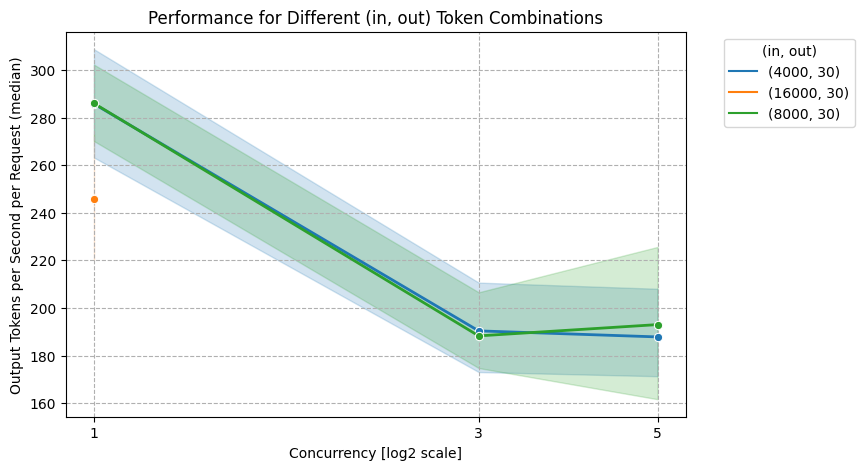

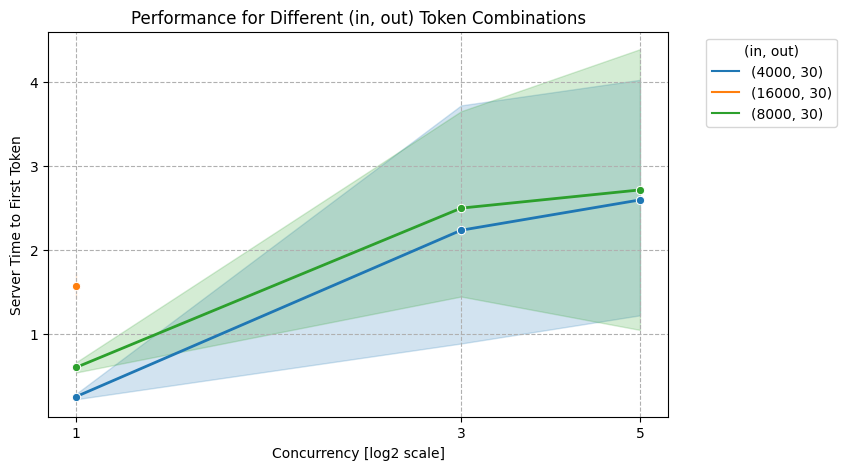

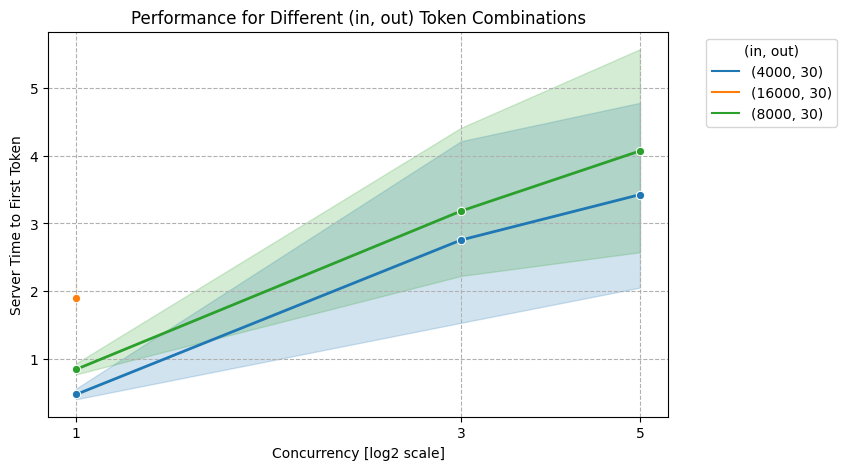

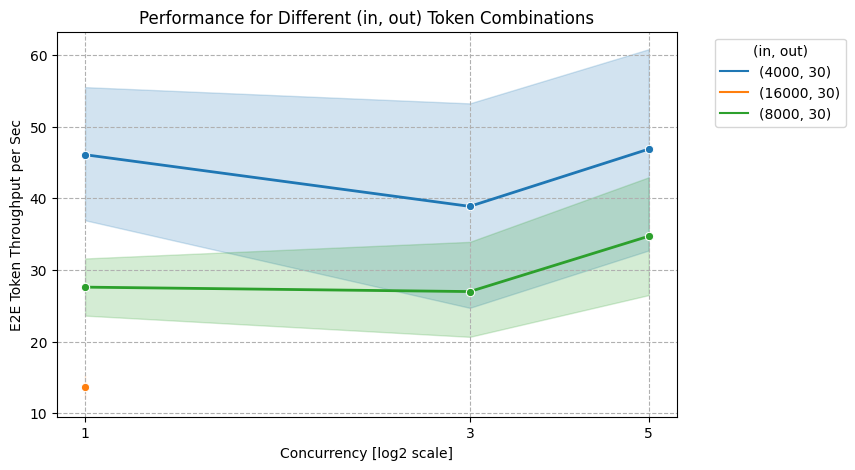

In [6]:
plot_benchmarking_data(df, 'server_output_token_per_s_p50', 'Output Tokens per Second per Request (median)')
plot_benchmarking_data(df, 'server_ttft_s_p50', 'Server Time to First Token')
plot_benchmarking_data(df, 'client_ttft_s_p50', 'Server Time to First Token')
plot_benchmarking_data(df, 'client_mean_output_token_per_s', 'E2E Token Throughput per Sec')


# Analyze switching time

__Note:__ This analysis will work if a Bundle endpoint is used. Users will be able to test and compare performance metrics for different experts.

In [39]:
import re
from typing import Optional

def find_uuid(file_name: str) -> Optional[str]:
    match = re.search(r'[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}', file_name)
    uuid = None
    if match:
        uuid = match.group()
    else:
        raise ValueError(f"UUID not found in filename {file_name}")
        
    return uuid

# post processing individual request json files
def read_json_files_to_df(directory: str) -> pd.DataFrame:
    data = []

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('individual_responses.json'):
            model_name = '_'.join(filename.split('_')[2:3])
            input_tokens = filename.split('_')[3]
            concurrent_requests = int(filename.split('_')[5])
            file_path = os.path.join(directory, filename)
            # Read the JSON file
            with open(file_path, 'r') as file:
                json_data = json.load(file)
                num_requests = len(json_data)
                # Extract relevant fields from each JSON object and append to the data list
                for item in json_data:
                    if pd.isnull(item['error_code']):
                        data.append(
                            {
                                'start_time': item['start_time'],
                                'end_time': item['end_time'],
                                'server_ttft_s': item['server_ttft_s'],
                                'client_ttft_s': item['client_ttft_s'],
                                'model_name': model_name,
                                'uuid': find_uuid(filename),
                                'input_tokens': input_tokens,
                                'concurrent_requests': concurrent_requests,
                                'filename': filename,
                                'num_requests': num_requests,
                            }
                        )

    # Create a DataFrame from the data list
    df = pd.DataFrame(data)
    return df

# Get the DataFrame
df = read_json_files_to_df(results_dir)
# df_2 = read_json_files_to_df(results_dir_2)

# df = pd.concat([df_1, df_2], ignore_index=True)

# transforming str to date time for sorting
df['start_time'] = pd.to_datetime(df['start_time'])
df = df.sort_values(by=['start_time'])

# transforming back to str for plotting
df['start_time_short'] = df['start_time'].dt.strftime(date_format='%H:%M:%S')
df.head(10)

,start_time,end_time,server_ttft_s,client_ttft_s,model_name,uuid,input_tokens,concurrent_requests,filename,num_requests,start_time_short
20,2025-06-18 11:11:54.337977,11:11:56.035913,0.334157,1.697016,Meta-Llama-3-3-70B-Instruct,aac3d6d7-94a4-40a5-9196-fb28ef8568ee,3900,1,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,1,11:11:54
15,2025-06-18 11:11:56.800753,11:11:59.008788,0.331575,2.207745,Meta-Llama-3-3-70B-Instruct,139f6c2a-668f-4d05-b6c7-234ae862cc81,3900,3,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,3,11:11:56
14,2025-06-18 11:11:56.800989,11:11:58.451526,0.626590,1.650054,Meta-Llama-3-3-70B-Instruct,139f6c2a-668f-4d05-b6c7-234ae862cc81,3900,3,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,3,11:11:56
13,2025-06-18 11:11:56.801162,11:11:58.450148,0.626590,1.648255,Meta-Llama-3-3-70B-Instruct,139f6c2a-668f-4d05-b6c7-234ae862cc81,3900,3,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,3,11:11:56
35,2025-06-18 11:11:59.756070,11:12:01.408094,0.627152,1.651811,Meta-Llama-3-3-70B-Instruct,fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c,3900,5,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,5,11:11:59
38,2025-06-18 11:11:59.756284,11:12:02.872756,1.195830,3.116429,Meta-Llama-3-3-70B-Instruct,fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c,3900,5,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,5,11:11:59
39,2025-06-18 11:11:59.756416,11:12:02.873413,1.195830,3.116957,Meta-Llama-3-3-70B-Instruct,fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c,3900,5,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,5,11:11:59
37,2025-06-18 11:11:59.757092,11:12:02.871934,1.195830,3.114719,Meta-Llama-3-3-70B-Instruct,fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c,3900,5,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,5,11:11:59
36,2025-06-18 11:11:59.757655,11:12:01.410096,0.627152,1.652279,Meta-Llama-3-3-70B-Instruct,fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c,3900,5,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,5,11:11:59
53,2025-06-18 11:12:03.617648,11:12:07.617760,2.291881,4.000162,Meta-Llama-3-3-70B-Instruct,be32cfc6-9d11-4b76-af77-f39ad40e89c1,3900,9,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,9,11:12:03


In [40]:
# get df start times lower than 00:00:00
def get_start_times_lower_greater_than(df, time_str, type):
    # Convert the time_str to a datetime object for comparison
    time_obj = pd.to_datetime(time_str, format='%H:%M:%S').time()
    
    if type == 'lt':
        # Filter the DataFrame
        filtered_df = df[df['start_time'].apply(lambda x: pd.to_datetime(x, format='%H:%M:%S').time()) < time_obj]
    elif type == 'gt':
        filtered_df = df[df['start_time'].apply(lambda x: pd.to_datetime(x, format='%H:%M:%S').time()) > time_obj]
    else:
        return None
    return filtered_df

df_first_part = get_start_times_lower_greater_than(df, '22:00:00', 'gt')
df_first_part['start_time'] = df_first_part['start_time'].apply(lambda dt: dt.replace(day=5))

df_second_part = get_start_times_lower_greater_than(df, '22:00:00', 'lt')

df = pd.concat([df_first_part, df_second_part])

# Convert datetime to full string with microseconds
df['start_time_str'] = df['start_time'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')

df.head(10)

,start_time,end_time,server_ttft_s,client_ttft_s,model_name,uuid,input_tokens,concurrent_requests,filename,num_requests,start_time_short,start_time_str
20,2025-06-18 11:11:54.337977,11:11:56.035913,0.334157,1.697016,Meta-Llama-3-3-70B-Instruct,aac3d6d7-94a4-40a5-9196-fb28ef8568ee,3900,1,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,1,11:11:54,2025-06-18 11:11:54.337977
15,2025-06-18 11:11:56.800753,11:11:59.008788,0.331575,2.207745,Meta-Llama-3-3-70B-Instruct,139f6c2a-668f-4d05-b6c7-234ae862cc81,3900,3,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,3,11:11:56,2025-06-18 11:11:56.800753
14,2025-06-18 11:11:56.800989,11:11:58.451526,0.626590,1.650054,Meta-Llama-3-3-70B-Instruct,139f6c2a-668f-4d05-b6c7-234ae862cc81,3900,3,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,3,11:11:56,2025-06-18 11:11:56.800989
13,2025-06-18 11:11:56.801162,11:11:58.450148,0.626590,1.648255,Meta-Llama-3-3-70B-Instruct,139f6c2a-668f-4d05-b6c7-234ae862cc81,3900,3,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,3,11:11:56,2025-06-18 11:11:56.801162
35,2025-06-18 11:11:59.756070,11:12:01.408094,0.627152,1.651811,Meta-Llama-3-3-70B-Instruct,fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c,3900,5,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,5,11:11:59,2025-06-18 11:11:59.756070
38,2025-06-18 11:11:59.756284,11:12:02.872756,1.195830,3.116429,Meta-Llama-3-3-70B-Instruct,fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c,3900,5,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,5,11:11:59,2025-06-18 11:11:59.756284
39,2025-06-18 11:11:59.756416,11:12:02.873413,1.195830,3.116957,Meta-Llama-3-3-70B-Instruct,fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c,3900,5,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,5,11:11:59,2025-06-18 11:11:59.756416
37,2025-06-18 11:11:59.757092,11:12:02.871934,1.195830,3.114719,Meta-Llama-3-3-70B-Instruct,fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c,3900,5,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,5,11:11:59,2025-06-18 11:11:59.757092
36,2025-06-18 11:11:59.757655,11:12:01.410096,0.627152,1.652279,Meta-Llama-3-3-70B-Instruct,fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c,3900,5,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,5,11:11:59,2025-06-18 11:11:59.757655
53,2025-06-18 11:12:03.617648,11:12:07.617760,2.291881,4.000162,Meta-Llama-3-3-70B-Instruct,be32cfc6-9d11-4b76-af77-f39ad40e89c1,3900,9,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,9,11:12:03,2025-06-18 11:12:03.617648


In [41]:
# Initialize a column for the switching time
df['server_switching_time'] = None

# Group by model_name
grouped = df.groupby('uuid')

# Iterate through each group to calculate switching time
for name, group in grouped:
    if len(group) > 1:
        first_ttft = group['server_ttft_s'].iloc[0]
        mean_ttft = group['server_ttft_s'].iloc[1:].mean()
        std_ttft = group['server_ttft_s'].iloc[1:].std()
        std_ttft = 1e-16 if np.isnan(std_ttft) else std_ttft
        switching_time = first_ttft - mean_ttft
        if switching_time > (mean_ttft + 3 * std_ttft):
            df.loc[group.index[0], 'server_switching_time'] = switching_time
        else:
            None
    else:
        df.loc[group.index[0], 'server_switching_time'] = None

# with pd.option_context(
#     'display.max_rows',
#     None,
# ):
#     display(df)

In [42]:
from typing import List, Tuple, Optional
def extract_file_info(file_name: str) -> Tuple[str, int, int, Optional[int], Optional[float]]:
    """Extract model, input, output, and concurrency from file name."""

    if 'multimodal' in file_name:
        _, _, model, _, _, in_tok, out_tok, con_type, *_ = file_name.split('_')
    else:
        _, _, model, in_tok, out_tok, con_type, *_ = file_name.split('_')

    if 'synthetic' in file_name:
        con = int(con_type)
        qps = None
    elif 'realworkload' in file_name:
        con = None
        qps = float(con_type.replace('-', '.'))

    return model, int(in_tok), int(out_tok), con, qps

def get_grouping_and_batching_info(df: pd.DataFrame) -> Tuple[List[int], List[int]]:
    """Generate grouping and batching info from DataFrame."""
    df = df.sort_values('end_time').reset_index(drop=True)
    df['group'] = (df['server_ttft_s'] != df['server_ttft_s'].shift()).cumsum()

    consecutive_counts = df.groupby(['group', 'server_ttft_s']).size().reset_index(name='consecutive_count')
    requests_grouping = consecutive_counts['consecutive_count'].tolist()
    requests_batching = [1 << (x - 1).bit_length() for x in requests_grouping]

    return requests_grouping, requests_batching

def find_uuid(file_name: str) -> Optional[str]:
    match = re.search(r'[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}', file_name)
    uuid = None
    if match:
        uuid = match.group()
    else:
        raise ValueError(f"UUID not found in filename {file_name}")
        
    return uuid

dict_groupings = {}

for filename in os.listdir(results_dir):
    if 'individual_responses' in filename:
        model_finame: str
        in_tok_finame: int
        out_tok_finame: int
        concurrency_finame: Optional[int]
        qps_finame: Optional[float]

        # model_finame, in_tok_finame, out_tok_finame, concurrency_finame, qps_finame = extract_file_info(
        #     filename
        # )
                
        df_file = df[df['filename'] == filename].copy()
        # df_file = df_file[df_file['error_code'].isnull()]

        requests_grouping, requests_batching = get_grouping_and_batching_info(df_file)
        
        dict_groupings[filename] = {
            'requests_grouping': requests_grouping,
            'requests_batching': requests_batching
        }
        
df_groupings = pd.DataFrame.from_dict(dict_groupings).T
df = df.merge(df_groupings, left_on='filename', right_index=True, how='left')
df

,start_time,end_time,server_ttft_s,client_ttft_s,model_name,uuid,input_tokens,concurrent_requests,filename,num_requests,start_time_short,start_time_str,server_switching_time,requests_grouping,requests_batching
20,2025-06-18 11:11:54.337977,11:11:56.035913,0.334157,1.697016,Meta-Llama-3-3-70B-Instruct,aac3d6d7-94a4-40a5-9196-fb28ef8568ee,3900,1,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,1,11:11:54,2025-06-18 11:11:54.337977,None,[1],[1]
15,2025-06-18 11:11:56.800753,11:11:59.008788,0.331575,2.207745,Meta-Llama-3-3-70B-Instruct,139f6c2a-668f-4d05-b6c7-234ae862cc81,3900,3,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,3,11:11:56,2025-06-18 11:11:56.800753,None,"[2, 1]","[2, 1]"
14,2025-06-18 11:11:56.800989,11:11:58.451526,0.626590,1.650054,Meta-Llama-3-3-70B-Instruct,139f6c2a-668f-4d05-b6c7-234ae862cc81,3900,3,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,3,11:11:56,2025-06-18 11:11:56.800989,None,"[2, 1]","[2, 1]"
13,2025-06-18 11:11:56.801162,11:11:58.450148,0.626590,1.648255,Meta-Llama-3-3-70B-Instruct,139f6c2a-668f-4d05-b6c7-234ae862cc81,3900,3,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,3,11:11:56,2025-06-18 11:11:56.801162,None,"[2, 1]","[2, 1]"
35,2025-06-18 11:11:59.756070,11:12:01.408094,0.627152,1.651811,Meta-Llama-3-3-70B-Instruct,fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c,3900,5,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,5,11:11:59,2025-06-18 11:11:59.756070,None,"[2, 3]","[2, 4]"
38,2025-06-18 11:11:59.756284,11:12:02.872756,1.195830,3.116429,Meta-Llama-3-3-70B-Instruct,fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c,3900,5,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,5,11:11:59,2025-06-18 11:11:59.756284,None,"[2, 3]","[2, 4]"
39,2025-06-18 11:11:59.756416,11:12:02.873413,1.195830,3.116957,Meta-Llama-3-3-70B-Instruct,fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c,3900,5,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,5,11:11:59,2025-06-18 11:11:59.756416,None,"[2, 3]","[2, 4]"
37,2025-06-18 11:11:59.757092,11:12:02.871934,1.195830,3.114719,Meta-Llama-3-3-70B-Instruct,fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c,3900,5,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,5,11:11:59,2025-06-18 11:11:59.757092,None,"[2, 3]","[2, 4]"
36,2025-06-18 11:11:59.757655,11:12:01.410096,0.627152,1.652279,Meta-Llama-3-3-70B-Instruct,fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c,3900,5,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,5,11:11:59,2025-06-18 11:11:59.757655,None,"[2, 3]","[2, 4]"
53,2025-06-18 11:12:03.617648,11:12:07.617760,2.291881,4.000162,Meta-Llama-3-3-70B-Instruct,be32cfc6-9d11-4b76-af77-f39ad40e89c1,3900,9,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,9,11:12:03,2025-06-18 11:12:03.617648,None,"[1, 8]","[1, 8]"


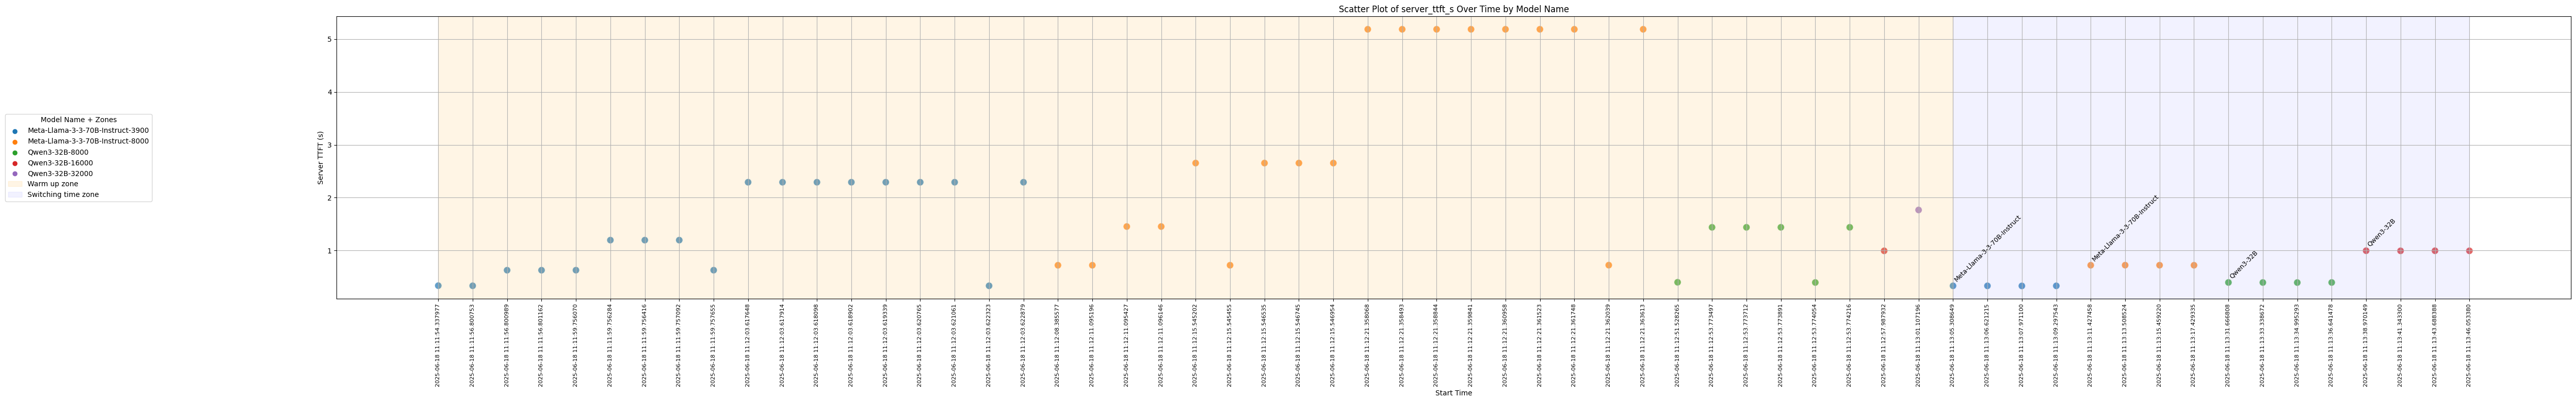

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a config column
def create_config_name(x):
    return f'{x[0]}-{x[1]}'

df['config'] = df[['model_name','input_tokens','concurrent_requests']].apply(lambda x: create_config_name(x), axis=1)

df = df.sort_values(by='start_time_str').reset_index(drop=True)

# Identify the switch point (first row where num_requests == 4 and concurrent_requests == 1)
switch_idx = df[(df['num_requests'] == 4) & (df['concurrent_requests'] == 1)].index.min()

# Get the corresponding x-value for that row to mark the zone boundary
switch_time = df.loc[switch_idx, 'start_time_str']

# Plot
plt.figure(figsize=(50, 8))
sns.scatterplot(x='start_time_str', y='server_ttft_s', hue='config', data=df, s=100, alpha=0.7)

# Add background color for "Warm up zone"
plt.axvspan(df['start_time_str'].iloc[0], switch_time, color='orange', alpha=0.1, label='Warm up zone')
# Add background color for "Switching time zone"
plt.axvspan(switch_time, df['start_time_str'].iloc[-1], color='blue', alpha=0.05, label='Switching time zone')

# Label first dot per uuid group after switch_idx
labeled_df = (
    df.loc[switch_idx:]  # data after switch
    .sort_values(by='start_time_str')  # ensure it's sorted
    .groupby('uuid', as_index=False)
    .first()  # first row per uuid after switch
)

for _, row in labeled_df.iterrows():
    plt.text(
        x=row['start_time_str'],
        y=row['server_ttft_s'] + 0.05,  # offset slightly above the dot
        s=row['model_name'],
        fontsize=9,
        color='black',
        rotation=45,
        ha='left',
        va='bottom'
    )

# Customize the plot
plt.title('Scatter Plot of server_ttft_s Over Time by Model Name')
plt.xlabel('Start Time')
plt.ylabel('Server TTFT (s)')
plt.legend(title='Model Name + Zones', loc='center left', bbox_to_anchor=(-0.15, 0.5))
plt.xticks(rotation='vertical', fontsize=8)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [46]:
# Group and compute first and second TTFT
def ttft_diff(group):
    if len(group) < 2:
        return None
    return round((group.iloc[0]["server_ttft_s"] - group.iloc[1]["server_ttft_s"])*1000,4)

# Apply grouping
result = df.groupby(['uuid']).apply(ttft_diff).reset_index()
result.columns = ["uuid", "ttft_diff_ms"]
# print(result)

df = df.merge(result, on='uuid', how='left')

In [47]:
with pd.option_context(
    'display.max_rows',
    None,
):
    display(df[['model_name', 'input_tokens','concurrent_requests','start_time_str', 'server_ttft_s', 'ttft_diff_ms', 'requests_batching', 'uuid']])

,model_name,input_tokens,concurrent_requests,start_time_str,server_ttft_s,ttft_diff_ms,requests_batching,uuid
0,Meta-Llama-3-3-70B-Instruct,3900,1,2025-06-18 11:11:54.337977,0.334157,NaN,[1],aac3d6d7-94a4-40a5-9196-fb28ef8568ee
1,Meta-Llama-3-3-70B-Instruct,3900,3,2025-06-18 11:11:56.800753,0.331575,-295.0153,"[2, 1]",139f6c2a-668f-4d05-b6c7-234ae862cc81
2,Meta-Llama-3-3-70B-Instruct,3900,3,2025-06-18 11:11:56.800989,0.626590,-295.0153,"[2, 1]",139f6c2a-668f-4d05-b6c7-234ae862cc81
3,Meta-Llama-3-3-70B-Instruct,3900,3,2025-06-18 11:11:56.801162,0.626590,-295.0153,"[2, 1]",139f6c2a-668f-4d05-b6c7-234ae862cc81
4,Meta-Llama-3-3-70B-Instruct,3900,5,2025-06-18 11:11:59.756070,0.627152,-568.6781,"[2, 4]",fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c
5,Meta-Llama-3-3-70B-Instruct,3900,5,2025-06-18 11:11:59.756284,1.195830,-568.6781,"[2, 4]",fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c
6,Meta-Llama-3-3-70B-Instruct,3900,5,2025-06-18 11:11:59.756416,1.195830,-568.6781,"[2, 4]",fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c
7,Meta-Llama-3-3-70B-Instruct,3900,5,2025-06-18 11:11:59.757092,1.195830,-568.6781,"[2, 4]",fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c
8,Meta-Llama-3-3-70B-Instruct,3900,5,2025-06-18 11:11:59.757655,0.627152,-568.6781,"[2, 4]",fa2a2452-0bbf-41eb-89c2-b5b3a2d5143c
9,Meta-Llama-3-3-70B-Instruct,3900,9,2025-06-18 11:12:03.617648,2.291881,0.0000,"[1, 8]",be32cfc6-9d11-4b76-af77-f39ad40e89c1


In [12]:
df[['model_name', 'input_tokens','concurrent_requests','start_time_str', 'server_ttft_s', 'ttft_diff_ms', 'requests_batching', 'uuid']].to_excel('llama_with_maitai_jie_list_1st_run_switching_time_table.xlsx')